In [1]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/DanP/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/DanP/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [45]:
data = pd.read_json("train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data['number_of_words_in_title']=data.apply(lambda x: len(x['request_title']), axis=1).astype(int)
data['number_of_words_in_text']=data.apply(lambda x: len(x['request_text']), axis=1).astype(int)
data['post_was_edited'] = data.apply(lambda x: 1 if "edit" in x['request_text'] else 0, axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
#data['requester_user_flair'] = data['requester_user_flair'].replace([None],"none")
#data['requester_user_flair'] = data['requester_user_flair'].astype("category").cat.codes
data.head(3)

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,request_text,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,year,month,day,dayofweek,number_of_words_in_title,number_of_words_in_text
0,0,1,0,0,Hi I am in need of food for my 4 children we a...,0.0000,792.420405,0.0,792.420405,0,...,0,1,0,1,2011,10,5,2,39,316
1,2,5,0,0,I spent the last money I had on gas today. Im ...,501.1111,1122.279838,0.0,621.127072,0,...,34,4258,116,11168,2012,3,25,6,57,74
2,0,3,0,0,My girlfriend decided it would be a good idea ...,0.0000,771.616181,0.0,771.616181,0,...,0,3,0,3,2011,10,26,2,66,277


In [62]:
from sklearn.cross_validation import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(2828, 27)
(2828,)
(1212, 27)
(1212,)


# Correlations

In [57]:
# Add train_data and labels to new dataframe to determine correlation matrix
train_data_for_corr = train_data
train_data_for_corr['requester_received_pizza'] = train_labels

corr_matrix = train_data_for_corr.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.453126
request_number_of_comments_at_retrieval                 0.295262
requester_number_of_comments_in_raop_at_retrieval       0.272092
number_of_upvotes_of_request_at_retrieval               0.130539
requester_number_of_comments_in_raop_at_request         0.127028
requester_days_since_first_post_on_raop_at_retrieval    0.126835
number_of_words_in_text                                 0.122062
requester_account_age_in_days_at_retrieval              0.120919
requester_number_of_posts_on_raop_at_request            0.107216
requester_number_of_comments_at_retrieval               0.103678
requester_days_since_first_post_on_raop_at_request      0.103172
requester_upvotes_minus_downvotes_at_retrieval          0.074930
post_was_edited                                         0.063629
requester_number_of_posts_at_retrieval                  0.051033
requester_upvotes_plus_do

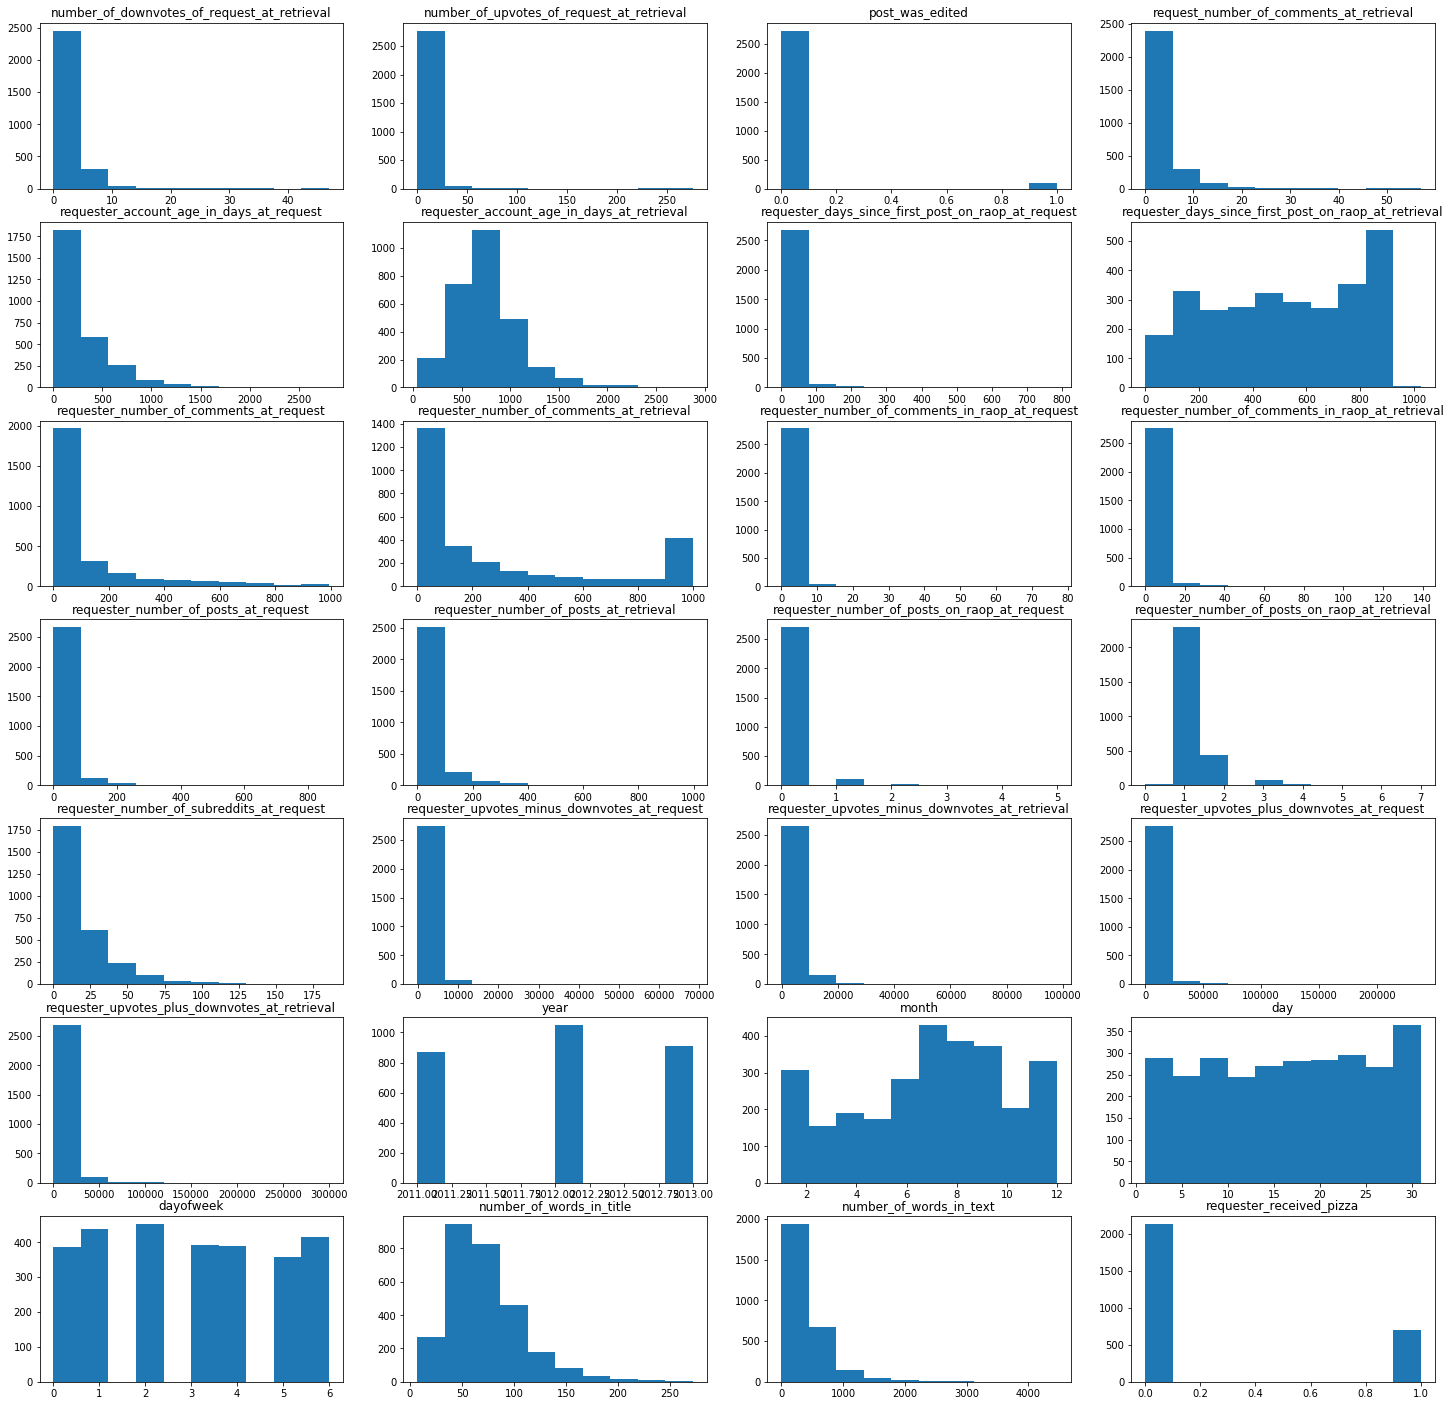

In [59]:
rows = 7
cols = 4

num_columns = []
for column in list(train_data):
    if train_data[column].dtype in {np.dtype('int64'),np.dtype('float64'),np.dtype('bool'),np.dtype('int8')}: 
        num_columns.append(column)
        
f, axarr = plt.subplots(rows,cols,figsize=(25,25))

column = 0
for row in range(rows):
    for col in range(cols):
        axarr[row,col].hist(train_data[num_columns[column]])
        axarr[row,col].set_title(num_columns[column])
        column += 1
        if column > len(num_columns)-1:
            break

plt.show()

In [91]:
lr = LogisticRegression().fit(train_data,train_labels)
y_pred = lr.predict(dev_data)
print "Accuracy = %1.3f" % lr.score(dev_data,dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.828
             precision    recall  f1-score   support

      False       0.84      0.95      0.89       903
       True       0.76      0.47      0.58       309

avg / total       0.82      0.83      0.81      1212



In [90]:
columns = ['requester_number_of_posts_on_raop_at_retrieval']

lr1 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr1.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr1.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.829
             precision    recall  f1-score   support

      False       0.85      0.93      0.89       903
       True       0.73      0.52      0.61       309

avg / total       0.82      0.83      0.82      1212



In [89]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval']

lr2 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr2.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr2.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.825
             precision    recall  f1-score   support

      False       0.83      0.96      0.89       903
       True       0.78      0.44      0.56       309

avg / total       0.82      0.83      0.81      1212



In [88]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval']

lr3 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr3.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr3.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.826
             precision    recall  f1-score   support

      False       0.84      0.95      0.89       903
       True       0.77      0.45      0.57       309

avg / total       0.82      0.83      0.81      1212



In [87]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval']

lr4 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr4.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr4.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.826
             precision    recall  f1-score   support

      False       0.84      0.95      0.89       903
       True       0.77      0.45      0.57       309

avg / total       0.82      0.83      0.81      1212



In [86]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request']

lr5 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr5.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr5.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.83      0.95      0.89       903
       True       0.76      0.44      0.56       309

avg / total       0.81      0.82      0.80      1212



In [85]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval']

lr6 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr6.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr6.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.825
             precision    recall  f1-score   support

      False       0.84      0.95      0.89       903
       True       0.77      0.45      0.57       309

avg / total       0.82      0.83      0.81      1212



In [84]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text']

lr7 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr7.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr7.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.83      0.95      0.89       903
       True       0.76      0.44      0.56       309

avg / total       0.81      0.82      0.80      1212



In [83]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text',
            'requester_account_age_in_days_at_retrieval']

lr8 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr8.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr8.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.823
             precision    recall  f1-score   support

      False       0.83      0.95      0.89       903
       True       0.77      0.44      0.56       309

avg / total       0.82      0.82      0.81      1212

